IMPORTS

In [10]:
from main import *
from neural_network import *
import time
import json
from dataset import Dataset
from rise_and_fall import *
from IPython.display import clear_output
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import scipy as sci
np.set_printoptions(precision=3, linewidth=2*75, suppress=False)
import os
import glob

PLOT FUNTIONS

In [ ]:
def plot_frame(f: pd.DataFrame, mxis=[], mnis=[], mark=None):
    ps = f["meanp"].to_numpy()
    mn = ps.min()
    mx = ps.max()
    plt.plot(ps)
    if len(mxis) > 0:
        plt.vlines(x=mxis, ymin=mn, ymax=mx, colors='green',)
    elif 'mxis' in f.columns:
        plt.vlines(x=f.index[f['mxis'] > 0], ymin=mn, ymax=mx, colors='green',)
    if len(mnis) > 0:
        plt.vlines(x=mnis, ymin=mn, ymax=mx, colors='red',)
    elif 'mnis' in f.columns:
        plt.vlines(x=f.index[f['mnis'] > 0], ymin=mn, ymax=mx, colors='red',)
    if mark is not None:
        plt.vlines(x=[mark], ymin=mn, ymax=mx, colors='blue',)
    plt.show()


def unique(xs):
    ys = []
    for x in xs:
        if x in ys:
            continue
        ys.append(x)
    return ys


INDICES CREATION FOR TRAINING VALIDATION AND TESTING

In [ ]:
# with open('database/channels.json') as file:
#     symbols = json.load(file)

# indices = []
# for symbol in symbols:
#     df = pd.read_csv(f"database/{symbol}.csv")
#     limit = df.shape[0]-1000
#     low = 1000
#     s,v = (int(limit*frac) for frac in [5/100, 10/100])
#     r = limit-s-v
#     s_ = np.random.randint(low, limit, size=s)

#     v_ = np.random.randint(low, limit, size=v)
#     similarity = np.isin(v_, s_)
#     while np.any(similarity):
#         v_[similarity] = np.random.randint(low, limit, v_[similarity].shape[0])
#         similarity = np.isin(v_, s_)
    
#     r_ = np.random.randint(low, limit, size=r)
#     similarity = np.isin(r_, np.append(v_, s_))
#     while np.any(similarity):
#         r_[similarity] = np.random.randint(low, limit, r_[similarity].shape[0])
#         similarity = np.isin(r_, np.append(v_, s_))
    
#     indices.append(
#         {
#             'symbol': symbol,
#             'r': r_,
#             's': s_,
#             'v': v_
#         }
#     )

# np.savez_compressed('database/indices.npz', indices=indices)

SAVING DATASETS IN NPY

In [ ]:
with open('database/channels.json') as file:
    symbols = json.load(file)

def save_set(x1, itter, symbol, sc):
    np.save(f'database/buy/{symbol}/{sc}x1.npy', x1)
    x2, y1, y2, y3, y4 = itter
    np.save(f'database/buy/{symbol}/{sc}x2.npy', x2)
    np.save(f'database/buy/{symbol}/{sc}y1.npy', y1)
    np.save(f'database/buy/{symbol}/{sc}y2.npy', y2)
    np.save(f'database/buy/{symbol}/{sc}y3.npy', y3)
    np.save(f'database/buy/{symbol}/{sc}y4.npy', y4)

dataset_size = 350000
trx1 = []; trothers = []
vlx1 = []; vlothers = []
tsx1 = []; tsothers = []

if __name__ == '__main__':
    for symbol in symbols:
        if symbol in [r.split('\\')[-1] for r in glob.glob('database/*') if '.' not in r]:
            continue
        print(symbol, ' started')
        db = Dataset(symbol)
        x1, others = db.get_data_set(
            batch_size=dataset_size, max_procs=4, single_process_size=int(dataset_size/4), buy=True, validation=False, test=False)

        norm = x1.max(axis=(0,1))
        norm[-1] = 288.0
        if not os.path.isdir(f'database/buy/{symbol}'):
            os.mkdir(f'database/buy/{symbol}')
        np.save(f'database/buy/{symbol}/norm.npy', norm)
        save_set(x1, others, symbol, 'tr')

        time.sleep(3*60)

        x1, others = db.get_data_set(
            batch_size=2**12, max_procs=8, single_process_size=512, buy=True, validation=True, test=False)
        save_set(x1, others, symbol, 'vl')

        x1, others = db.get_data_set(
            batch_size=2**12, max_procs=8, single_process_size=512, buy=True, validation=False, test=True)
        save_set(x1, others, symbol, 'ts')

        time.sleep(5*60)
        

MODEL TESTING

In [19]:
def test(symbol, show=True):
    plt.figure(figsize=(15, 4))
    mtypes = ['ch', 'bs', 'p']
    yps=[]
    yas=[]
    r2s = []
    for mt in mtypes:
        model = get_bp_model(symbol, 3e-4, mt, allow_base=False)
        _,_,data = normalized_data(symbol, mt)
        yp = model.predict(data[:2], batch_size=512, verbose=0)
        yps.extend(yp) if type(yp)==list else yps.append(yp)
        ya = data[2:]
        yas.extend(ya) if type(ya)==list else yas.append(ya)
    
    for i in range(4):
        slope, intercept, r_value, p_value, std_err = sci.stats.linregress(yas[i], yps[i].flatten())
        plt.subplot(1, len(yas), i+1)
        plt.plot(yas[i], slope*yas[i]+intercept, c='r')
        plt.text(0.0, 0.0, f'R2: {np.round(r_value**2, 2)}')
        plt.scatter(yas[i], yps[i])
        r2s.append(r_value**2)
    if show:
        plt.show()
    else:
        return r2s

ADAUSDT
46429864 selected
Retrived Trained Model
48506853 selected
Retrived Trained Model
40266422 selected
Retrived Trained Model


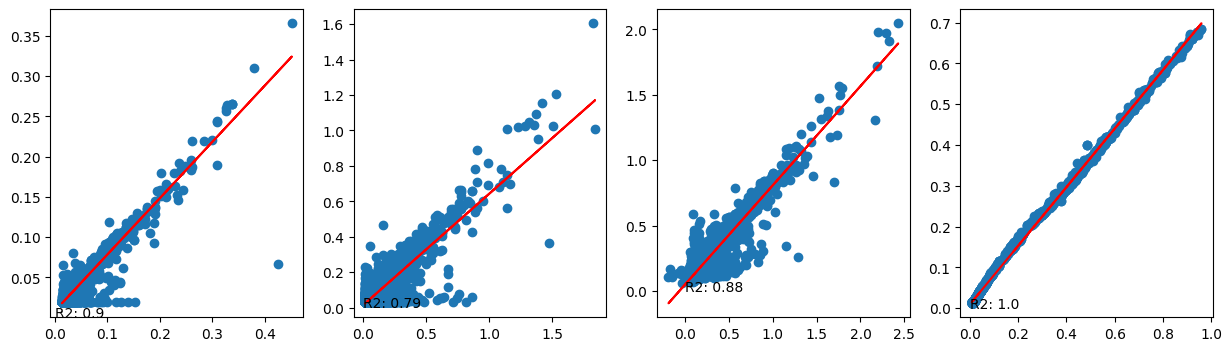

BNBUSDT
12982742 selected
Retrived Trained Model
57467356 selected
Retrived Trained Model
16065835 selected
Retrived Trained Model


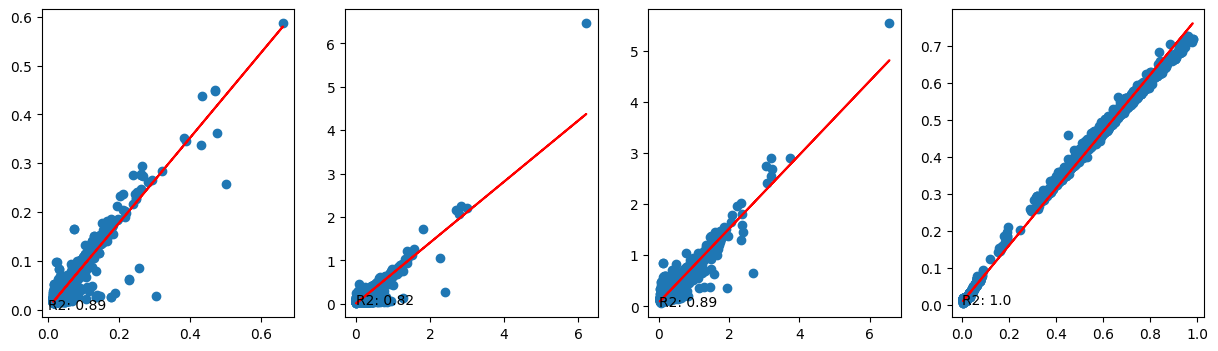

BTCUSDT
39869040 selected
Retrived Trained Model
49781852 selected
Retrived Trained Model
13673492 selected
Retrived Trained Model


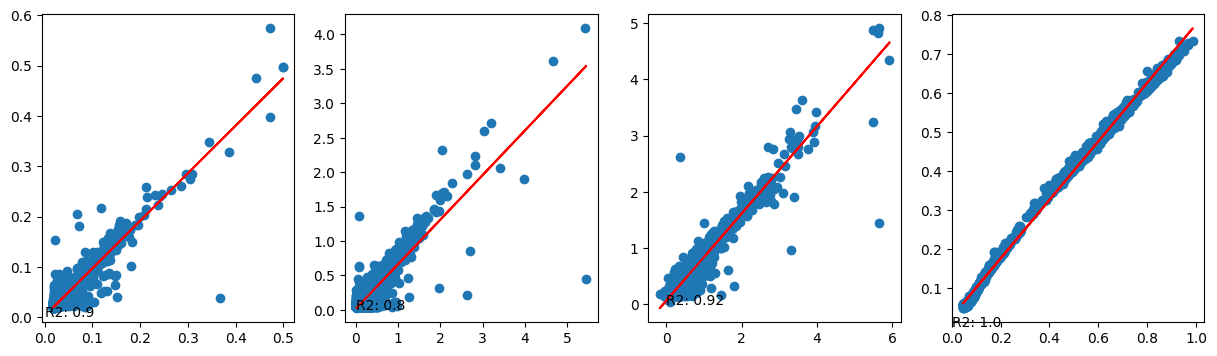

DOGEUSDT
64142183 selected
Retrived Trained Model
73499955 selected
Retrived Trained Model
43331782 selected
Retrived Trained Model


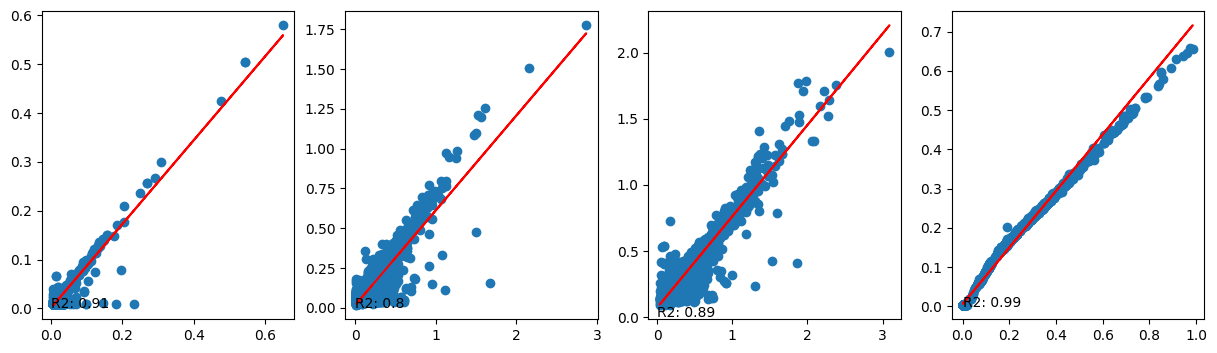

ETHUSDT
44515078 selected
Retrived Trained Model
60950453 selected
Retrived Trained Model
89609308 selected
Retrived Trained Model


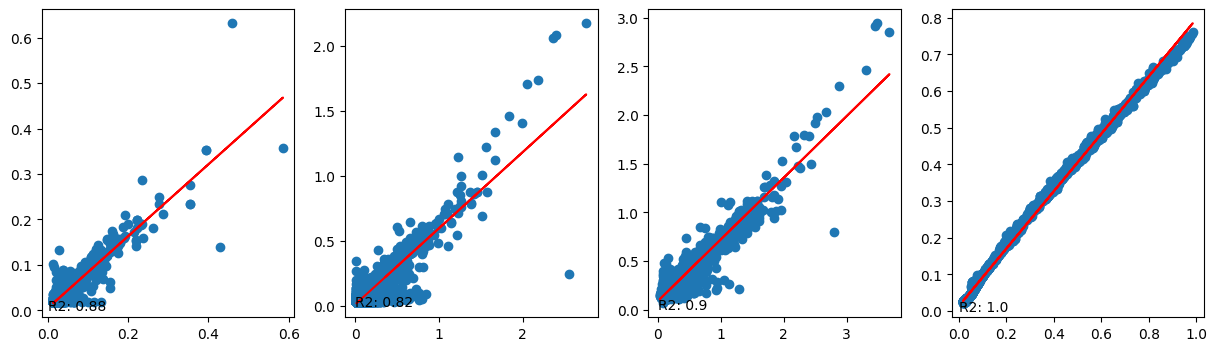

LINKUSDT
83226850 selected
Retrived Trained Model
23666863 selected
Retrived Trained Model
43602005 selected
Retrived Trained Model


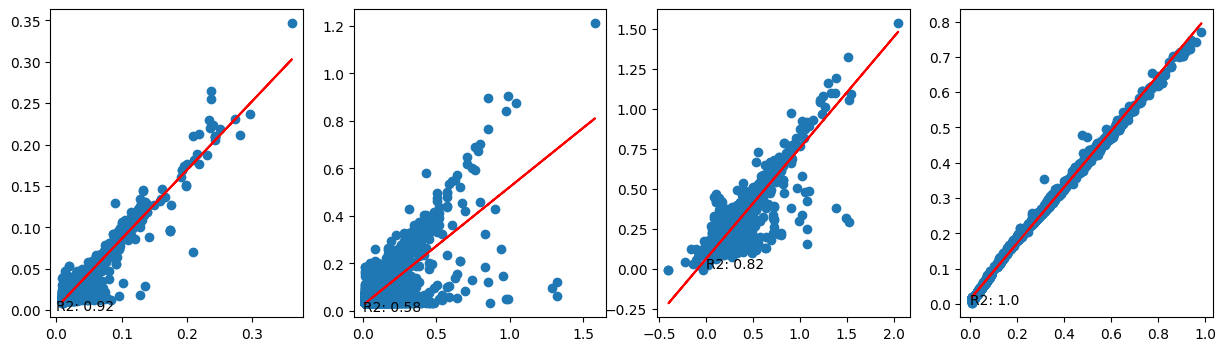

LTCUSDT
62646360 selected
Retrived Trained Model
47191717 selected
Retrived Trained Model
69678384 selected
Retrived Trained Model


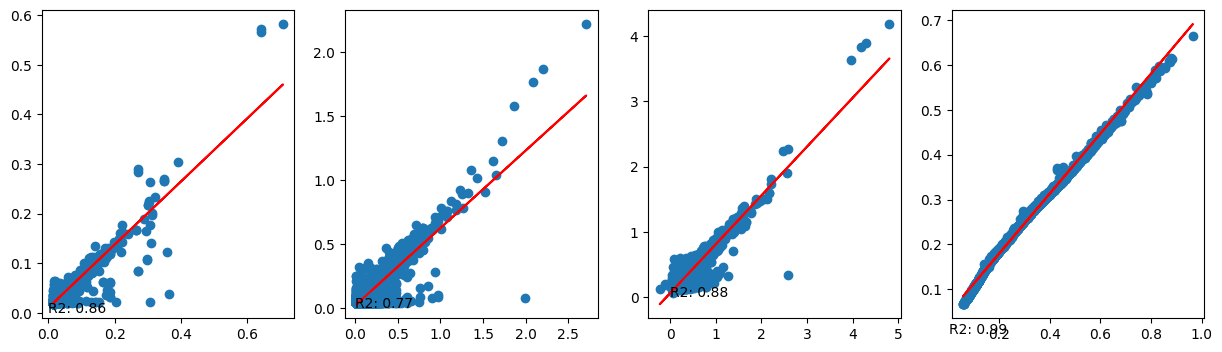

SHIBUSDT
20295596 selected
Retrived Trained Model
90989770 selected
Retrived Trained Model
56002983 selected
Retrived Trained Model


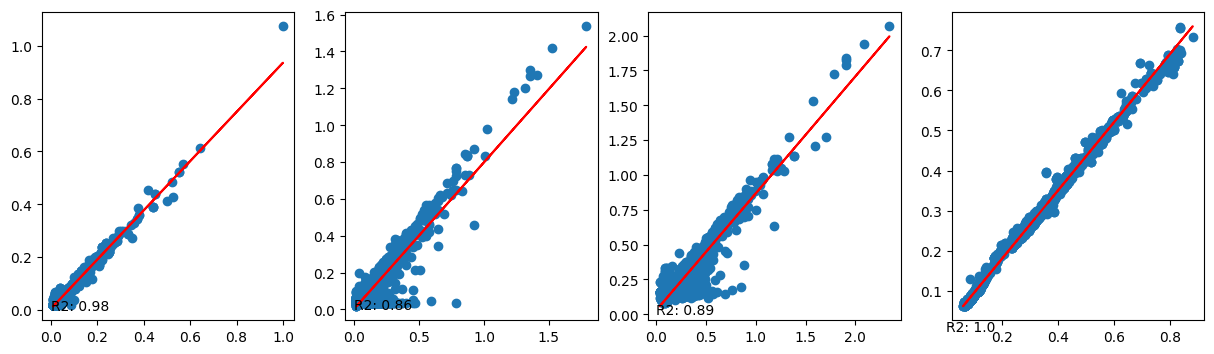

SOLUSDT
37279000 selected
Retrived Trained Model
04727885 selected
Retrived Trained Model
95834339 selected
Retrived Trained Model


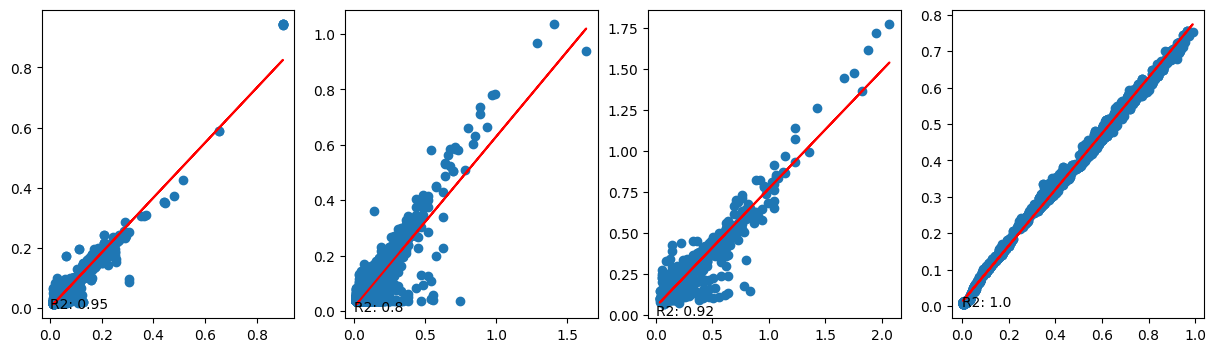

TRXUSDT
24345937 selected
Retrived Trained Model
76557989 selected
Retrived Trained Model
84657762 selected
Retrived Trained Model


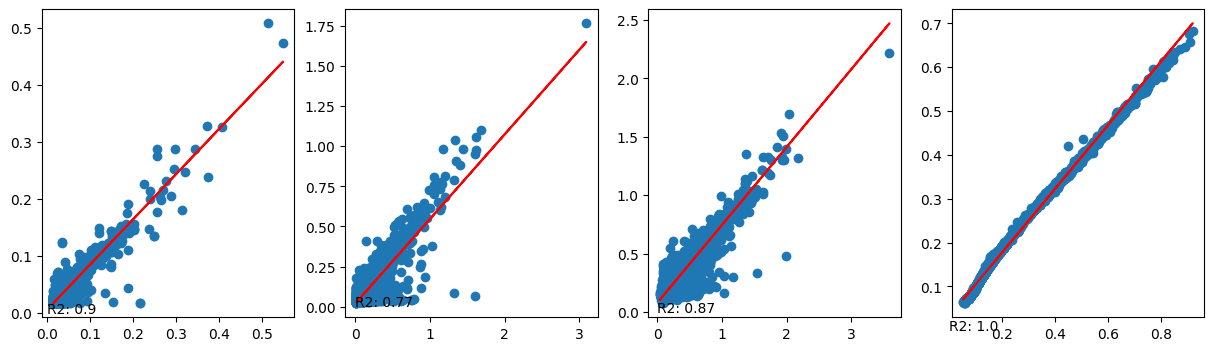

XRPUSDT
50268131 selected
Retrived Trained Model
89673127 selected
Retrived Trained Model
48889732 selected
Retrived Trained Model


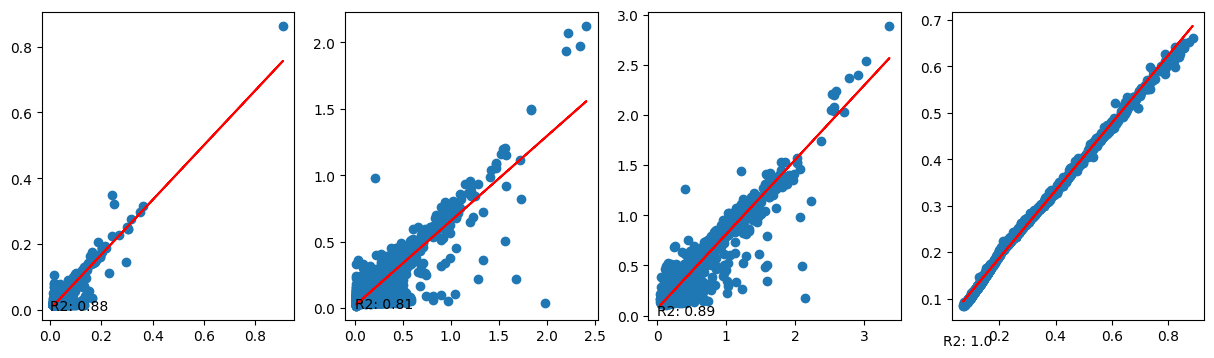

In [20]:
for symbol in [r.split('\\')[-1] for r in glob.glob('database/buy/*') if '.' not in r]:
    try:
        print(symbol)
        test(symbol)
    except:
        pass

RANDOM

In [21]:
# results=[]
# for mtype in ['ch', 'bs', 'p']:
#     if mtype=='ch':
#         model = ch_predictor()
#     elif mtype=='bs':
#         model = bs_predictor()
#     elif mtype=='p':
#         model = p_predictor()
#     else:
#         raise Exception("Invalid mtype")
#     symbols = [r.split('\\')[-1] for r in glob.glob('database/buy/*') if '.' not in r]
#     for symbol in symbols:
#         with open(f'database/buy/{symbol}/{mtype}_history/version_history.json', 'r') as file:
#             version_history = json.load(file)
#         model_name = version_history[-1]['id']
#         model.load_weights(f'database/buy/{symbol}/{mtype}_history/{model_name}.h5')
#         _,_,data = normalized_data(symbol, mtype)
        
#         yp = model.predict(data[:2], batch_size=1024, verbose=0)
#         ya = data[2:]
#         if type(yp)==list:
#             for ind in range(len(yp)):
#                 res= {
#                 'symbol':symbol,
#                 'mtype':f"{mtype}_ind",
#                 'ya':ya[ind],
#                 'yp':yp[ind].flatten()
#             }
#             results.append(res)
#         else:
#             res= {
#                 'symbol':symbol,
#                 'mtype':mtype,
#                 'ya':ya,
#                 'yp':yp.flatten()
#             }
#             results.append(res)



In [ ]:
# model = buy_predictor(finetune=True)
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# model.summary()